In [3]:
import datetime
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

%matplotlib inline

In [4]:
# merge all files
files_list = ['turnstile_161210.txt','turnstile_161217.txt']

df_list = [pd.read_csv(file) for file in files_list]

df_all = pd.concat(df_list)

In [5]:
def load_files(df):
    df.columns = [col.strip() for col in list(df.columns)] # remove whitespaces

    #obtain the difference for entries and exits to get the count
    df['total_entries'] = df.ENTRIES.shift(-1) - df.ENTRIES
    df['total_exits'] = df.EXITS.shift(-1) - df.EXITS

    # remove outliers if negative or greater than 200,000 in any single time period
    df = df[(df.total_entries > 0 )  & (df.total_entries < 20000) & (df.total_exits > 0) & (df.total_exits < 20000)]

    # datetime format
    df['datetime'] = pd.to_datetime(df.DATE + df.TIME, format='%m/%d/%Y%H:%M:%S')
    # drop unnecessary columns
    df = df.drop(['DIVISION', 'DESC', 'ENTRIES', 'EXITS'], 1)
    
    return df


In [6]:
total_df = load_files(df_all)

/Users/mac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
total_df['DATE'] = total_df['datetime'].dt.date

In [8]:
# only count the traffic for 11AM - 3PM
total_df = total_df[(total_df['TIME'] == '11:00:00') | (total_df['TIME'] == '15:00:00')]
total_df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,total_entries,total_exits,datetime
2,A002,R051,02-00-00,59 ST,NQR456W,2016-12-03,11:00:00,244.0,77.0,2016-12-03 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,2016-12-03,15:00:00,496.0,91.0,2016-12-03 15:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,2016-12-04,11:00:00,230.0,70.0,2016-12-04 11:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,2016-12-04,15:00:00,343.0,80.0,2016-12-04 15:00:00
14,A002,R051,02-00-00,59 ST,NQR456W,2016-12-05,11:00:00,265.0,89.0,2016-12-05 11:00:00
15,A002,R051,02-00-00,59 ST,NQR456W,2016-12-05,15:00:00,995.0,85.0,2016-12-05 15:00:00
20,A002,R051,02-00-00,59 ST,NQR456W,2016-12-06,11:00:00,239.0,94.0,2016-12-06 11:00:00
21,A002,R051,02-00-00,59 ST,NQR456W,2016-12-06,15:00:00,1020.0,88.0,2016-12-06 15:00:00
26,A002,R051,02-00-00,59 ST,NQR456W,2016-12-07,11:00:00,226.0,89.0,2016-12-07 11:00:00
27,A002,R051,02-00-00,59 ST,NQR456W,2016-12-07,15:00:00,905.0,102.0,2016-12-07 15:00:00


In [9]:
import calendar

total_df['Weekday'] = [calendar.day_name[d.weekday()] for d in total_df['DATE']]
total_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,total_entries,total_exits,datetime,Weekday
2,A002,R051,02-00-00,59 ST,NQR456W,2016-12-03,11:00:00,244.0,77.0,2016-12-03 11:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,2016-12-03,15:00:00,496.0,91.0,2016-12-03 15:00:00,Saturday
8,A002,R051,02-00-00,59 ST,NQR456W,2016-12-04,11:00:00,230.0,70.0,2016-12-04 11:00:00,Sunday
9,A002,R051,02-00-00,59 ST,NQR456W,2016-12-04,15:00:00,343.0,80.0,2016-12-04 15:00:00,Sunday
14,A002,R051,02-00-00,59 ST,NQR456W,2016-12-05,11:00:00,265.0,89.0,2016-12-05 11:00:00,Monday


In [10]:
group_by_stationline = total_df.groupby(['STATION','LINENAME']).sum().reset_index()
group_by_stationline['total'] = group_by_stationline.total_entries + group_by_stationline.total_exits

In [11]:
group_by_stationline[['STATION','LINENAME','total']].sort_values(by=['total'],ascending=False).head(20)

,STATION,LINENAME,total
50,34 ST-HERALD SQ,BDFMNQRW,1647933.0
53,34 ST-PENN STA,ACE,989875.0
62,47-50 STS ROCK,BDFM,913721.0
171,GRD CNTRL-42 ST,4567S,889653.0
228,TIMES SQ-42 ST,1237ACENQRSW,837210.0
91,86 ST,456,804572.0
77,59 ST COLUMBUS,ABCD1,747718.0
73,59 ST,456NQRW,680597.0
160,FLUSHING-MAIN,7,611172.0
58,42 ST-BRYANT PK,BDFM7,569953.0


In [12]:
MANHAT=['TIMES SQ-42 ST','14 ST-UNION SQ','GRD CNTRL-42 ST','116 ST-COLUMBIA','14 ST-6 AVE',
        '66 ST-LINCOLN','59 ST COLUMBUS','34 ST-HERALD SQ','5 AVE-BRYANT PK','34 ST-PENN STA', 
        'W 4 ST-WASH SQ','42 ST-PORT AUTH','47-50 STS ROCK','LEXINGTON AV/53','86 ST', '59 ST',
        'CANAL ST', 'SPRING ST', 'WALL ST', 'CHAMBERS ST', '14 ST', '8 ST-NYU', '23 ST', '96 ST', '125 ST']

In [13]:
top_15 = group_by_stationline[group_by_stationline['STATION'].isin(MANHAT)].sort_values(by='total',ascending=False).head(15)

In [14]:
top_15['station_line'] = top_15[['STATION','LINENAME']].apply(lambda x: '--'.join(x),axis=1)
top_15

,STATION,LINENAME,total_entries,total_exits,total,station_line
50,34 ST-HERALD SQ,BDFMNQRW,903723.0,744210.0,1647933.0,34 ST-HERALD SQ--BDFMNQRW
53,34 ST-PENN STA,ACE,482150.0,507725.0,989875.0,34 ST-PENN STA--ACE
62,47-50 STS ROCK,BDFM,577947.0,335774.0,913721.0,47-50 STS ROCK--BDFM
171,GRD CNTRL-42 ST,4567S,517814.0,371839.0,889653.0,GRD CNTRL-42 ST--4567S
228,TIMES SQ-42 ST,1237ACENQRSW,437216.0,399994.0,837210.0,TIMES SQ-42 ST--1237ACENQRSW
91,86 ST,456,428678.0,375894.0,804572.0,86 ST--456
77,59 ST COLUMBUS,ABCD1,466556.0,281162.0,747718.0,59 ST COLUMBUS--ABCD1
73,59 ST,456NQRW,395679.0,284918.0,680597.0,59 ST--456NQRW
189,LEXINGTON AV/53,EM6,349654.0,195298.0,544952.0,LEXINGTON AV/53--EM6
59,42 ST-PORT AUTH,ACENQRS1237W,232123.0,293201.0,525324.0,42 ST-PORT AUTH--ACENQRS1237W


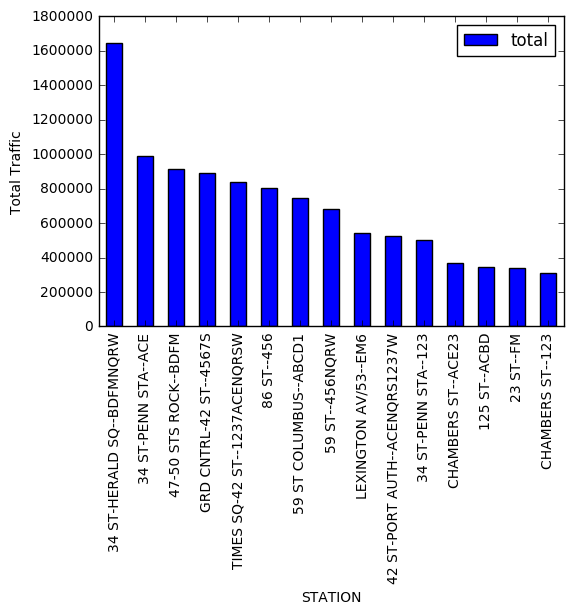

In [15]:
top_15.plot.bar(x='station_line', y='total')

plt.xlabel('STATION')
plt.ylabel('Total Traffic')
plt.savefig('top15.png')

In [16]:
top15_stations = top_15['station_line'].tolist()
top15_stations

['34 ST-HERALD SQ--BDFMNQRW',
 '34 ST-PENN STA--ACE',
 '47-50 STS ROCK--BDFM',
 'GRD CNTRL-42 ST--4567S',
 'TIMES SQ-42 ST--1237ACENQRSW',
 '86 ST--456',
 '59 ST COLUMBUS--ABCD1',
 '59 ST--456NQRW',
 'LEXINGTON AV/53--EM6',
 '42 ST-PORT AUTH--ACENQRS1237W',
 '34 ST-PENN STA--123',
 'CHAMBERS ST--ACE23',
 '125 ST--ACBD',
 '23 ST--FM',
 'CHAMBERS ST--123']

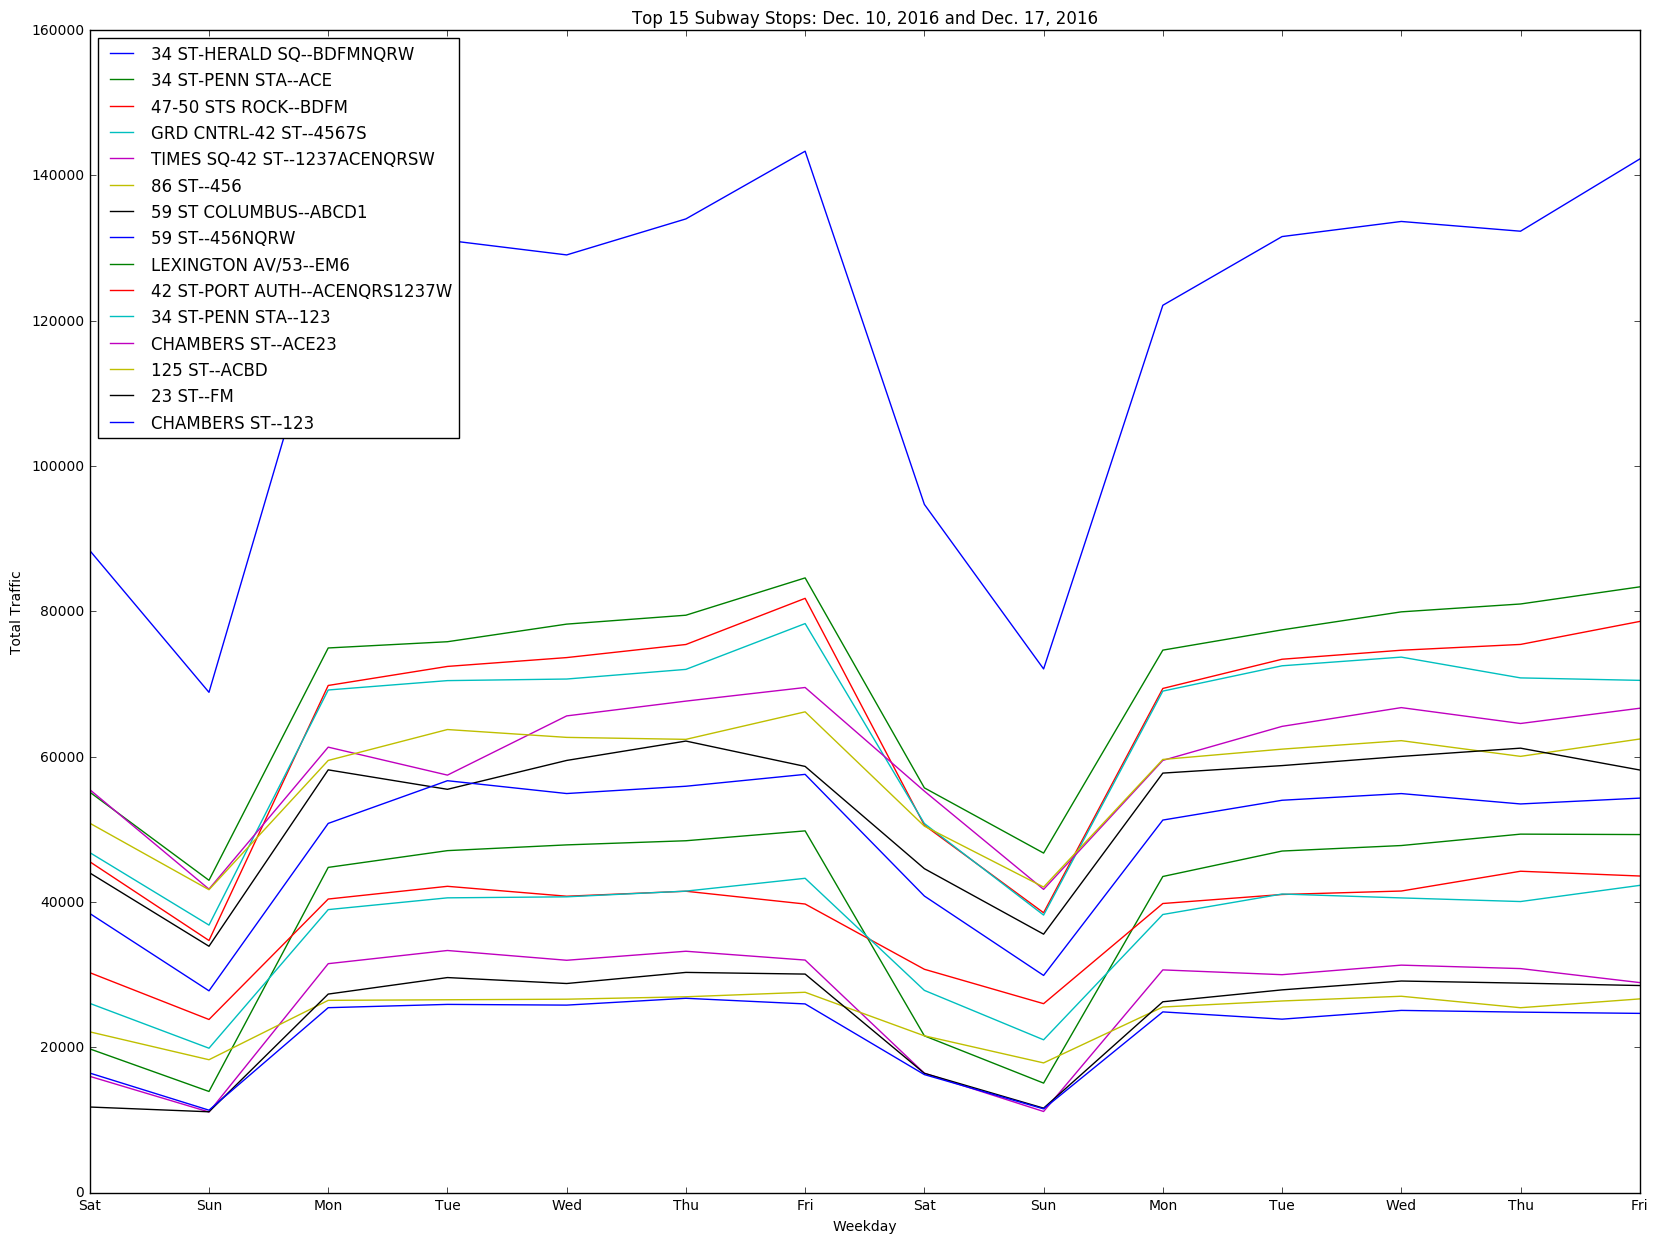

In [17]:
# function to graph the top 15 stations grouped by linename as well

def top_stations_plot(df, station_list):
    
    df['total'] = df['total_entries'] + df['total_exits']
    df['station_line'] = df[['STATION', 'LINENAME']].apply(lambda x: '--'.join(x), axis=1)
    grouped = df.groupby(['station_line'])

    plt.figure(figsize=(20,15))

    for station in station_list:
        s = grouped.get_group(station)
        t = s.groupby('DATE').sum()
        x = t.index
        y = t.total
        plt.plot(x, y, label = station)
        
    plt.xlabel('Weekday')
    plt.ylabel('Total Traffic')
    plt.legend(loc = 'upper left')
    plt.xticks(x, ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']*2)

top_stations_plot(total_df, top15_stations)
plt.title('Top 15 Subway Stops: Dec. 10, 2016 and Dec. 17, 2016')
plt.savefig('top15_timeseries.png')

In [23]:
# load demographics data
df_demo = pd.read_csv('Station_Zipcode.csv',encoding='utf-8', engine='python')

In [28]:
df_demo

,Station-Line,Zipcode,Females,Males
0,34 ST-HERALD SQ--BDFMNQRW,10001,0.498,0.502
1,34 ST-PENN STA--ACE,10001,0.498,0.502
2,47-50 STS ROCK--BDFM,10020,0.354,0.646
3,GRD CNTRL-42 ST--4567S,10017,0.538,0.462
4,TIMES SQ-42 ST--1237ACENQRSW,10036,0.427,0.573
5,86 ST--456,10028,0.563,0.437
6,59 ST COLUMBUS--ABCD1,10019,0.505,0.495
7,59 ST--456NQRW,10022,0.559,0.441
8,LEXINGTON AV/53--EM6,10022,0.559,0.441
9,42 ST-PORT AUTH--ACENQRS1237W,10036,0.427,0.573


In [38]:
df_demo.rename(columns={'Station-Line': 'station_line'},inplace=True)

In [39]:
top_15.columns

Index(['STATION', 'LINENAME', 'total_entries', 'total_exits', 'total',
       'station_line'],
      dtype='object')

In [40]:
df_demo.columns

Index(['station_line', 'Zipcode', 'Females', 'Males'], dtype='object')

In [48]:
top_15 = top_15.merge(df_demo, on='station_line', how='left')

In [53]:
top_15['female_ratio'] = top_15['Females'] / top_15['Males']
top_15_sort = top_15.sort_values(by=('female_ratio'),ascending=False)

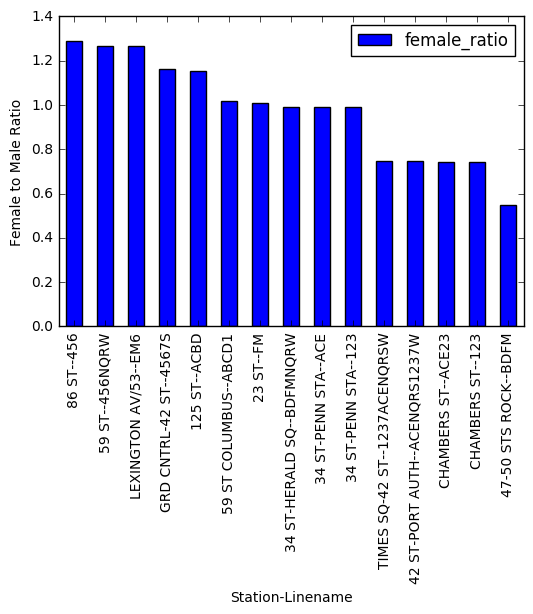

In [55]:
top_15_sort.plot.bar(x='station_line', y='female_ratio')
plt.xlabel('Station-Linename')
plt.ylabel('Female to Male Ratio')
plt.savefig('top_15_femaleratio')